# Introduction to Logistic Regression in PyTorch

In this notebook, we're going to build a very simple neural network in PyTorch to do handwritten digit classification.
First, we'll start with some exploration of the MNIST dataset, explaining how we load and format the data.
We'll then jump into motivating and then implementing the logistic regression model, including the forward and backwards pass, loss functions, and optimizers.
After training the model, we'll evaluate how we did and visualize what we've learned.
Finally, we'll refactor our code in an object-oriented manner, using higher level APIs.

Before we get started, some imports for the packages we'll be using:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

### MNIST Dataset

The MNIST dataset is very popular machine learning dataset, consisting of 70000 grayscale images of handwritten digits, of dimensions 28x28. 
We'll be using it as our example dataset for this section of the tutorial, with the goal being to predict which digit is in each image.

![mnist](Figures/mnist.png)

The first (and often most important) step in machine learning is preparing the data.
This can include downloading, organizing, formatting, shuffling, pre-processing, augmenting, and batching examples so that they can be fed to a model.
The `torchvision` package makes this easy by implementing many of these, allowing us to put these datasets into a usable form in only a few lines of code.
First, let's download the train and test sets of MNIST:

In [2]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

  0%|          | 16384/9912422 [00:00<01:23, 119019.50it/s]

9920512it [00:01, 5902326.53it/s]                             


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw


32768it [00:00, 288980.14it/s]                           
0it [00:00, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw


1654784it [00:00, 2132467.30it/s]                            
8192it [00:00, 151636.36it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw
Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw
Processing...
Done!


In [3]:
print("Number of MNIST training examples: {}".format(len(mnist_train)))
print("Number of MNIST test examples: {}".format(len(mnist_test)))

Number of MNIST training examples: 60000
Number of MNIST test examples: 10000


As we'd expect, 60000 of the MNIST examples are in the train set, and the rest are in the test set.
We added the transform `ToTensor()` when formatting the dataset, to convert the input data from a Pillow `Image` type into a PyTorch `Tensor`. Tensors will eventually be the input type that we feed into our model. 

Let's look at an example image from the train set and its label.
Notice that the `image` tensor defaults to something 3-dimensional.
The "1" in the first dimension indicates that the image only has one channel (i.e. grayscale).
We need to get rid of this to visualize the image with `imshow`.

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
The label for this image: 1


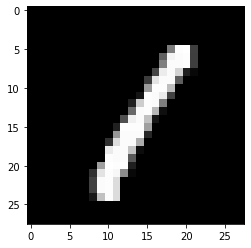

In [7]:
# Pick out the 4th (0-indexed) example from the training set
image, label = mnist_train[3]

# Plot the image
print("Default image shape: {}".format(image.shape))
image = image.reshape([28,28])

print("Reshaped image shape: {}".format(image.shape))
plt.imshow(image, cmap = 'gray')

# Print the label
print("The label for this image: {}".format(label))

While we could work directly with the data as a `torchvision.dataset`, we'll find it useful to use a `DataLoader`, which will take care of shuffling and batching:

In [8]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

An example of a minibatch drawn from a `DataLoader`:

In [9]:
data_train_iter = iter(train_loader)
images, labels = data_train_iter.next()

print("Shape of the minibatch of images: {}".format(images.shape))
print("Shape of the minibatch of labels: {}".format(labels.shape))

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


#### Checkpoint

If you had any difficulties typing the above code, the below are the lines necessary for the next section.
Simply uncomment the entire cell block (`Ctrl/Cmd + A` -> `Ctrl/Cmd + /`), and then run the cell.
If you've followed along so far, you can skip this cell block.

In [ ]:
# %matplotlib inline

# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# from torchvision import datasets, transforms
# from tqdm.notebook import tqdm

# # Load MNIST dataset
# mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
# mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

# # Create DataLoaders for train and test sets
# train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
# test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

### Logistic Regression Model

Now that we have a good feel for how to load our data, let's start putting together our model. 
In this tutorial, we'll be building a logistic regression model, which is essentially a fully-connected neural network without any hidden layers. 
While fairly basic, logistic regression can perform surprisingly well on many simple classification tasks.

#### The forward pass

While our data inputs (which we'll call `x`) are images (i.e. 2-dimensional), MNIST digits are pretty small, and the model we're using is very simple.
Thus, we're going to be treating the input as flat vectors.
To convert our inputs into row vectors (a.k.a. flattening), we can use `view()`, the equivalent of NumPy's `reshape()`.
Also like NumPy, we can replace one of the dimensions of the reshaping with a `-1`, which tells PyTorch to infer this dimension based on the original dimensions and the other specified dimensions.
Let's do try this flattening on the minibatch of 100 images we drew in the previous section.

In [10]:
x = images.view(-1, 28*28)
print("The shape of input x: {}".format(x.shape))

The shape of input x: torch.Size([100, 784])


To get our predicted probabilities of each digit, let's first start with the probability of a digit being a 1 like the image above. 
For our simple model, we can start by applying a linear transformation. 
That is, we multiply each pixel $x_i$ of the input row vector by a weight $w_{i,1}$, sum them all together, and then add a bias $b_1$.
This is equivalent to a dot product between the class "1" weights and the input:

\begin{align}
y_1 = \sum_i x_i w_{i,1} + b_1
\end{align}

The magnitude of this result $y_1$, we'll take as being correlated to our belief in how likely we think the input digit was a 1. 
The higher the value of $y_1$, the more likely we think the input image $x$ was a 1 (i.e., we'd hope we'd get a relatively large value for $y_1$ for the above image). 
Remember though, our original goal was to identify all 10 digits, so we actually have:

\begin{align*}
y_0 =& \sum_i x_i w_{i,0} + b_0 \\
y_1 =& \sum_i x_i w_{i,1} + b_1 \\
y_2 =& \sum_i x_i w_{i,2} + b_2 \\
y_3 =& \sum_i x_i w_{i,3} + b_3 \\
y_4 =& \sum_i x_i w_{i,4} + b_4 \\
y_5 =& \sum_i x_i w_{i,5} + b_5 \\
y_6 =& \sum_i x_i w_{i,6} + b_6 \\
y_7 =& \sum_i x_i w_{i,7} + b_7 \\
y_8 =& \sum_i x_i w_{i,8} + b_8 \\
y_9 =& \sum_i x_i w_{i,9} + b_9
\end{align*}

We can express this in matrix form as:

\begin{align}
y = x W + b 
\end{align}

To take advantage of parallel computation, we commonly process multiple inputs $x$ at once, in a minibatch.
We can stack each input $x$ into a matrix $X$, giving us 

\begin{align}
Y = X W + b 
\end{align}

Visualizing the dimensions:

<img src="Figures/mnist_matmul.PNG" width="500"/>

In our specific example, the minibatch size $m$ is $100$, the dimension of the data is $28 \times 28=784$, and the number of classes $c$ is $10$.
While $X$ and $Y$ are matrices due to the batching, conventionally, they are often given lowercase variable names, as if they were for a single example.
We will use `x` and `y` throughout.

The weight $W$ and bias $b$ make up the parameters of this model.
When we say that we want to "learn the model," what we're really trying to do is find good values for every element in $W$ and $b$.
Before we begin learning, we need to initialize our parameters to some value, as a starting point.
Here, we don't really know what the best values are, so we going to initialize $W$ randomly (using something called [Xavier initialization](http://proceedings.mlr.press/v9/glorot10a.html)), and set $b$ to a vector of zeros.

In [11]:
# Randomly initialize weights W
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()

# Initialize bias b as 0s. Creating a vector of 10 zeros. 
b = torch.zeros(10, requires_grad=True)

As both `W` and `b` are parameters we wish to learn, we set `requires_grad` to `True`. 
This tells PyTorch's autograd to track the gradients for these two variables, and all the variables depending on `W` and `b`.

With these model parameters, we compute $y$:

In [13]:
# Linear transformation with W and b
y = torch.matmul(x, W) + b

We can see for example what the predictions look like for the first example in our minibatch. Remember, the bigger the number, the more the model thinks the input $x$ is of that class.

In [14]:
print(y[0, :])

tensor([-0.0386,  0.0087, -0.5075,  0.3904,  0.2876, -0.0624,  0.0831, -0.3559,
         0.0219, -0.6552], grad_fn=<SliceBackward>)


We can interpret these values (aka logits) $y$ as probabilities if we normalize them to be positive and add up to 1. In logistic regression, we do this with a softmax:

\begin{align}
p(y_i) = \text{softmax}(y_i) = \frac{\text{exp}(y_i)}{\sum_j\text{exp}(y_j)}
\end{align}

Notice that because the range of the exponential function is always non-negative, and since we're normalizing by the sum, the softmax achieves the desired property of producing values between 0 and 1 that sum to 1. If we look at the case with only 2 classes, we see that the softmax is the multi-class extension of the binary sigmoid function: 

<img src="Figures/Logistic-curve.png" width="300"/>

We can compute the softmax ourselves using the above formula if we'd like, but PyTorch already has the softmax function in `torch.nn.functional`:

In [15]:
# Option 1: Softmax to probabilities from equation
py_eq = torch.exp(y) / torch.sum(torch.exp(y), dim=1, keepdim=True)
print("py[0] from equation: {}".format(py_eq[0]))

# Option 2: Softmax to probabilities with torch.nn.functional
import torch.nn.functional as F
py = F.softmax(y, dim=1)
print("py[0] with torch.nn.functional.softmax: {}".format(py_eq[0]))

py[0] from equation: tensor([0.0997, 0.1045, 0.0624, 0.1531, 0.1381, 0.0973, 0.1126, 0.0726, 0.1059,
        0.0538], grad_fn=<SelectBackward>)
py[0] with torch.nn.functional.softmax: tensor([0.0997, 0.1045, 0.0624, 0.1531, 0.1381, 0.0973, 0.1126, 0.0726, 0.1059,
        0.0538], grad_fn=<SelectBackward>)


We've now defined the forward pass of our model: given an input image, the graph returns the probabilities the model thinks the input is each of the 10 classes. Are we done?

#### The cross-entropy loss

This tutorial isn't done yet, so you can probably guess that the answer is not quite. 
We don't know the values of $W$ and $b$ yet! 
Remember how we initialized them randomly? 
Before we adjust any of the weights, we need a way to measure how the model is doing.
Specifically, we're going to measure how badly the model is doing.
We do this with a *loss* function, which takes the model's prediction and returns a single number (i.e. a scalar) summarizing model performance.
This loss will inform how we adjust the parameters of the model.

The loss we commonly use in classification is cross-entropy, a concept from information theory.
Explaining exactly what the cross-entropy represents goes slightly beyond the scope of this course, but you can think of it as a way of quantifying how far apart one distribution $y'$ is from another $y$.

\begin{align}
H_{y'}(y)=-\sum_i y'_i \text{log}(y_i)
\end{align}

In our case, $y$ is the set of probabilities predicted by the model ($py$ above); $y'$ is the target distribution.
What is the target distribution?
It's the true label, which is what we wanted the model to predict.

Cross-entropy not only captures how *correct* (max probability corresponds to the right answer) the model's answers are, it also accounts for how *confident* (high confidence in correct answers) they are. This encourages the model to produce very high probabilities for correct answers while driving down the probabilities for the wrong answers, instead of merely being satisfied with it being the argmax. 

We focus here on supervised learning, a setting in which we have the labels.
Our `DataLoader` automatically includes the corresponding labels for each of our inputs.
Here are the labels from the first time we retrieved a minibatch:

In [17]:
print(labels.shape)

torch.Size([100])


Like the softmax operation, we can implement the cross-entropy directly from the equation, using the softmax output.
However, as with the softmax, `torch.nn.functional` already has the cross-entropy loss implemented as well.

In [20]:
# Cross-entropy loss from equation
cross_entropy_eq = torch.mean(-torch.log(py_eq)[range(labels.shape[0]),labels])
print("cross entropy from equation: {}".format(cross_entropy_eq))

# Option 2: cross-entropy loss with torch.nn.functional
cross_entropy = F.cross_entropy(y, labels)
print("cross entropy with torch.nn.functional.cross_entropy: {}".format(cross_entropy))

cross entropy from equation: 2.296306848526001
cross entropy with torch.nn.functional.cross_entropy: 2.296306848526001


Note that PyTorch's cross-entropy loss combines the softmax operator and cross-entropy into a single operation, for numerical stability reasons.
Don't do the softmax twice!
Make sure to feed in the pre-softmax logits `y`, not the post-softmax probabilities `py`.

#### The backwards pass

Now that we have the loss as a way of quantifying how badly the model is doing, we can improve our model by changing the parameters in a way that minimizes the loss.
For neural networks, the common way of doing this is with backpropagation: we take the gradient of the loss with respect to $W$ and $b$ and take a step in the direction that reduces our loss.

If we were not using a deep learning framework like PyTorch, we would have to go through and derive all the gradients ourselves by hand, then code them into our program. 
We certainly still could.
However, with modern auto-differentiation libraries, it's much faster and easier to let the computer do it.

First, we need to create an optimizer.
There are many choices, but since logistic regression is fairly simple, we'll use standard stochastic gradient descent (SGD), which makes the following update:

\begin{align}
\theta_{t+1} = \theta_t - \alpha \nabla_\theta \mathcal{L}
\end{align}

where $\theta$ is a parameter, $\alpha$ is our learning rate (step size), and $\nabla_\theta \mathcal{L}$ is the gradient of our loss with respect to $\theta$.

In [21]:
# Optimizer. lr = "learning rate" = step size.
optimizer = torch.optim.SGD([W, b], lr=0.1)

When we created our parameters $W$ and $b$, we indicated that they require gradients.
To compute the gradients for $W$ and $b$, we call the `backward()` function on the cross-entropy loss.

In [22]:
cross_entropy.backward()

Each of the variables that required gradients have now accumulated gradients.
We can see these for example on `b`:

In [23]:
b.grad

tensor([-0.0131, -0.0547,  0.0033,  0.0125,  0.0538, -0.0131,  0.0295,  0.0311,
         0.0170, -0.0663])

To apply the gradients, we could manually update $W$ and $b$ using the update rule $\theta_{t+1} = \theta_t - \alpha \nabla_\theta \mathcal{L}$, but since we have an optimizer, we can tell it to perform the update step for us:

In [24]:
optimizer.step()

We set our learning rate to 0.1, so `b` has been updated by `-0.1*b.grad`:

In [25]:
b

tensor([ 0.0013,  0.0055, -0.0003, -0.0012, -0.0054,  0.0013, -0.0029, -0.0031,
        -0.0017,  0.0066], requires_grad=True)

We've now successfully trained on a minibatch!
However, one minibatch probably isn't enough.
At this point, we've trained the model on 100 examples out of the 60000 in the training set.
We're going to need to repeat this process, for more of the data.

One more thing to keep in mind though: gradients calculated by `backward()` don't override the old values; instead, they accumulate.
Therefore, you'll want to clear the gradient buffers before you compute gradients for the next minibatch.

In [26]:
print("b.grad before zero_grad(): {}".format(b.grad))
optimizer.zero_grad()
print("b.grad after zero_grad(): {}".format(b.grad))

b.grad before zero_grad(): tensor([-0.0131, -0.0547,  0.0033,  0.0125,  0.0538, -0.0131,  0.0295,  0.0311,
         0.0170, -0.0663])
b.grad after zero_grad(): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


#### Model Training

To train the model, we just need repeat what we just did for more minibatches from the training set.
As a recap, the steps were:
1. Draw a minibatch
2. Zero the gradients in the buffers for `W` and `b`
3. Perform the forward pass (compute prediction, calculate loss)
4. Perform the backward pass (compute gradients, perform SGD step)

Going through the entire dataset once is referred to as an epoch.
In many cases, we train neural networks for multiple epochs, but here, a single epoch is enough.
We also wrap the train_loader with `tqdm`.
This isn't neccessary, but it adds a handy progress bar so we can track our training progress.

In [28]:
# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

#### Testing

Now let's see how we did! 
For every image in our test set, we run the data through the model, and take the digit in which we have the highest confidence as our answer. 
We then compute an accuracy by seeing how many we got correct.
We're going to wrap evaluation with `torch.no_grad()`, as we're not interested in computing gradients during evaluation.
By turning off the autograd engine, we can speed up evaluation.

In [30]:
correct= 0
total = len(mnist_test)

# Iterate through test set minibatchs 
for images, labels in tqdm(test_loader):
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    
    predictions = torch.argmax(y, dim=1)
    correct += torch.sum((predictions == labels).float())
    
    
    
print('Test accuracy: {}'.format(correct/total))


Test accuracy: 0.9021000266075134


Not bad for a simple model and a few lines of code.
Before we conclude this example, there's one more interesting thing we can do. 
Normally, it can be difficult to inspect exactly what the filters in a model are doing, but since this model is so simple, and the weights transform the data directly to their logits, we can actually visualize what the model's learning by simply plotting the weights. 
The results look pretty reasonable:

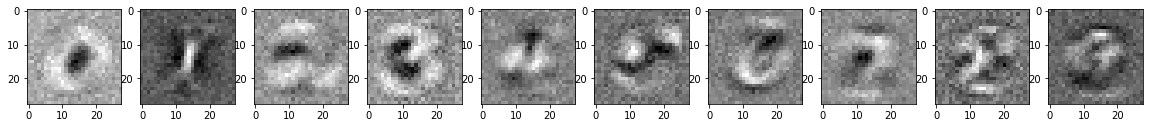

In [31]:
# # Get weights
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
   ax[digit].imshow(W[:,digit].detach().view(28,28), cmap='gray')

As we can see, the model learned a template for each digit.
Remember that our model takes a dot product between the weights of each digit and input.
Therefore, the more the input matches the template for a digit, the higher the value of the dot product for that digit will be, which makes the model more likely to predict that digit.

#### The Full Code

The entire model, with the complete model definition, training, and evaluation (but minus the weights visualization) as independently runable code:

In [32]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Initialize parameters
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()
b = torch.zeros(10, requires_grad=True)

# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))


Test accuracy: 0.9023000001907349


Note: The accuracy from the full version directly above might return a slightly different test accuracy from the step-by-step version we first went through. 
We trained our model with stochastic gradient descent (SGD), with the word "stochastic" highlighting that training is an inherently random process.

### Higher level APIs

So far, we've primarily been building neural networks with fairy basic PyTorch operations.
We did this to provide a clearer picture of how models actually work and what's going on under the hood.
This can be important as you're learning concepts and the various frameworks, and sometimes the low-level control is necessary if you're trying to build something novel.

However, most of the time, we do find ourselves repeating the same fairly standard lines of code, which can slow us down. 
Worse, it clutters up our code unnecessarily and introduces room for bugs and typos.
And finally, as researchers or engineers, we would like to spend most of our time thinking on the highest levels of abstractions: I want to add a convolution layer here, then a fully-connected there, etc.
Having to code all the small details are distractions that can detract from our ability to translate ideas into code.
For this reason, PyTorch has higher level abstractions to help speed up implementation and improve model organization.
While there are many ways to organize PyTorch code, one common paradigm is with `torch.nn.Module`.

#### Object-oriented Refactorization

It often makes sense for us to code our models in an [object-oriented manner](https://realpython.com/python3-object-oriented-programming/).
To understand why, let's look back at the linear transformation $y = xW + b$ that we used for logistic regression. 
We can see that while the operation consisted of a matrix multiplication and addition, also associated with this operation was the instantiation of two parameters `W` and `b`, and these two parameters conceptually *belong* to the transform.
As such, it would make sense to bundle up the instantiation of the two parameters with the actual transformation:

In [36]:
# Note: illustrative example only; see below for torch.nn usage
class xW_plus_b:
    def __init__(self, dim_in, dim_out):
        self.W = torch.randn(dim_in, dim_out)/np.sqrt(dim_in)
        self.W.requires_grad_()
        self.b = torch.zeros(dim_out, requires_grad=True)
        
    def forward(self, x):
        return torch.matmul(x, self.W) + self.b

To use what we just wrote, we can create an `xW_plus_b` instance using its `__init__()` method (the constructor).
In this case, we're going to set the dimensions to be 784 and 10, as we did in our logisitic regression example above.
This creates an `xW_plus_b` instance with two parameters `W` and `b`.

In [37]:
# Note: illustrative example only; see below for torch.nn usage
lin_custom = xW_plus_b(784, 10)

print("W: {}".format(lin_custom.W))
print("b: {}".format(lin_custom.b))

W: tensor([[ 0.0202,  0.0315, -0.0069,  ..., -0.0066, -0.0354,  0.0140],
        [ 0.0523,  0.0084,  0.0048,  ..., -0.0237,  0.0285,  0.0391],
        [-0.0282,  0.0130, -0.0383,  ...,  0.0388, -0.0503, -0.0036],
        ...,
        [-0.0325, -0.0225,  0.0051,  ...,  0.0424, -0.0393, -0.0675],
        [-0.0505, -0.0567,  0.0247,  ...,  0.0042, -0.0251,  0.0488],
        [ 0.0645,  0.0316, -0.0075,  ...,  0.0371, -0.0578, -0.0054]],
       requires_grad=True)
b: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


After instantiating the instance, we can perform the actual linear transform of our custom `xW_plus_b` class by calling the instance's `forward()` function:

In [38]:
# Note: illustrative example only; see below for torch.nn usage
x_rand = torch.randn(1, 784)
y = lin_custom.forward(x_rand)
print(y.shape)

torch.Size([1, 10])


#### Using  `torch.nn`

While we can certainly implement our own classes for the operations we'd like to use, we don't have to, as PyTorch already has them in the `torch.nn` sublibrary. 

In [46]:
import torch.nn as nn

For example, the linear transform example we just went through is called `torch.nn.Linear`:

In [47]:
lin = nn.Linear(784, 10)
print("Linear parameters: {}".format([p.shape for p in lin.parameters()]))


print()

Linear parameters: [torch.Size([10, 784]), torch.Size([10])]



The implementation for `nn.Linear` has a few more things under the hood (notice for example that the `forward()` function is aliased with calling the instance itself), but in spirit, it operates in much the same way as our custom `xW_plus_b` class.
In the first line, we instantiate a `Linear` object, which automatically creates weight and bias variables of the specified dimensions.
The fourth line then calls the `forward()` function (aliased with the object call), which performs the linear transformation.

#### Using `torch.nn.Module`

The `torch.nn.Linear` class we just saw is a subclass of `torch.nn.Module`.
However, `Module`s do not have to just describe a single operation; they can also define a chain of operations, each of which may also be `Module`s.
As such, we can place our entire neural network within a `Module`.
In this case, the module can track all of its associated parameters, some of which may also be associated with a submodule (e.g. `nn.Linear`), while also defining the `forward()` function, in one place.

In [48]:
class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, X):
        return self.lin(x)

In this particular example, we didn't need to chain any operations, but we'll see this come in handy as we move on to more complex models.
Additionally, the `nn.Module` that we subclassed has a few other nice features.
For example:
- The `forward()` function of a `nn.Module` will call the `forward()` function of any child `nn.Module`s.
- `print()` will print out a formatted summary of our model, recursively summarizing any child `nn.Module`s as well.
- The `parameters()` function will return a generator that returns all parameters of a `nn.Module` (including those of any children).

In [51]:
model = MNIST_Logistic_Regression()
y = model(x_rand)

print("The model: \n{}".format(model))
print("\nParameters: \n{}".format(list(model.parameters())))
print("\nOutput shape: \n{}".format(y.shape))

The model: 
MNIST_Logistic_Regression(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

Parameters: 
[Parameter containing:
tensor([[ 1.4002e-02, -1.9939e-02, -1.2380e-02,  ...,  3.3691e-02,
         -2.0969e-02,  2.5738e-02],
        [ 4.7877e-03, -2.3507e-02,  4.9837e-03,  ...,  9.7965e-03,
          1.7446e-02,  2.0653e-03],
        [ 3.3381e-02,  2.5008e-02,  5.1290e-03,  ...,  2.8389e-02,
          3.2121e-02, -2.2292e-02],
        ...,
        [-3.3116e-02, -1.9066e-02, -2.2490e-03,  ...,  9.7365e-03,
         -2.9794e-02,  6.0594e-03],
        [-1.6772e-02,  3.2312e-02, -5.0858e-03,  ...,  2.5439e-02,
         -3.9978e-03, -2.4900e-02],
        [ 1.9208e-02,  2.1160e-02, -2.6984e-04,  ...,  2.2923e-02,
         -2.8674e-05,  1.6812e-02]], requires_grad=True), Parameter containing:
tensor([ 0.0281, -0.0258,  0.0040,  0.0070, -0.0154,  0.0235,  0.0311, -0.0073,
        -0.0075,  0.0044], requires_grad=True)]

Output shape: 
torch.Size([100, 10])


#### Full code with `nn.Module`

Refactoring our previous complete logistic regression code to use a `nn.Module`:

In [52]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, x):
        return self.lin(x)

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Instantiate model
model = MNIST_Logistic_Regression()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = criterion(y, labels)
    # Backward pass
    loss.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = model(x)
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))


Test accuracy: 0.9024999737739563


While the benefits of organizing a model as a `nn.Module` may not be as obvious for a simple logistic regression model, such a programming style allows for much quicker and cleaner implementations for more complex models, as we'll see in later notebooks.